#### Инициализация

In [3]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crosssection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

rows, columns = (768, 1024)
'''Калибровка'''# [cm/px]
Kx_abs = 0.0006272973203202318

#### Обработка поглощения

In [135]:
file_abs = "image_13"
#directory = r"..//" #EXPERIMENTS
#directory = r"../..//" #desktop
directory = r"../2025-10-08_densityScan_b=115/d=6.37V//" #EXPERIMENTS

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file_abs + ".tif") #initially a grayscale image

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) #go to next frame
except EOFError: #end of frames case
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0
bias = shots[2]

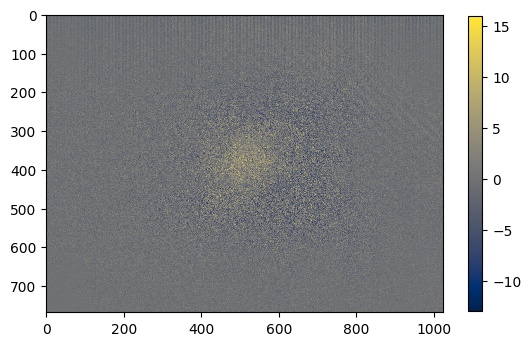

In [136]:
'''Приведение к uint16 и замена нулей, чтобы не возникало ошибок при делении матриц'''
num = (I_atoms - bias).astype(np.uint16) + 1
denom = (I_lbeam - bias).astype(np.uint16) + 1

'''Определение пропускания T(x,y)'''
T = (num/denom).astype(np.float32)

'''Визуализация'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="cividis", interpolation="none")
plt.colorbar(shrink=.8)

#### Поиск центра облака

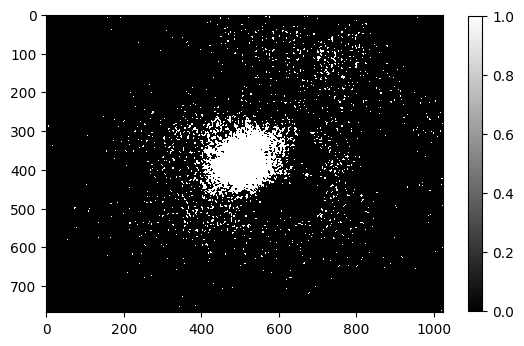

In [137]:
'''Фильтрация физичных T<=1'''
F = np.copy(T)
for i in range(rows):
    for j in range(columns):
        if T[i, j] > 1:
            F[i, j] = 1

'''Сглаживание шумов'''
M = cv2.medianBlur(F, 5)

TRSH = .99
'''Фильтрация пропускания ниже порогового значения'''
_, binary = cv2.threshold(M, TRSH, 1, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV:
#  ≤ TRSH = белые
#  > TRSH = черные

'''Визуализация'''
plt.imshow(binary, cmap="gray", interpolation='none')
plt.colorbar(shrink=.8)

Критическое пропускание	Tc: 0.9776453375816345
Критическая точка	C: (379, 506) 


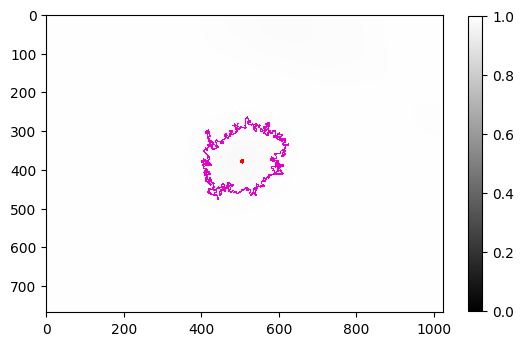

In [138]:
'''Выделение контура поглощения'''
contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert contours != (), "Err: no contours found"

filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if y > binary.shape[0] * 0.2:
        filtered_contours.append(contour)
assert filtered_contours != (), "Err: no contours meets filtering condition"

largest_contour = max(filtered_contours, key=cv2.contourArea)
ROI = np.zeros_like(T, dtype=np.uint8)
cv2.drawContours(ROI, [largest_contour], -1, 255, thickness=cv2.FILLED)

G = cv2.GaussianBlur(M, (0, 0), sigmaX=50)
#G = cv2.bilateralFilter(M, d=1, sigmaColor=1e-8, sigmaSpace=1e-8)
'''Нахождение минимума пропускания в нём'''
min_val, _, (jc_abs, ic_abs), _ = cv2.minMaxLoc(G, mask=ROI)
print(f"Критическое пропускание\tTc: {min_val}\nКритическая точка\tC: {(ic_abs, jc_abs)} ")

'''Отрисовка полученного контура'''
output = cv2.cvtColor(G, cv2.COLOR_GRAY2BGR)  # Переводим в BGR для рисования
cv2.drawContours(output, [largest_contour], -1, (.9, 0, .8), 2)
cv2.circle(output, (jc_abs, ic_abs), 6, (1., 0, 0), -1)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output, interpolation='none', cmap="gray")
plt.colorbar(shrink=.8)

#### Обработка центральной горизонтали

fwhm: 134.235 ± 3.116 px
peak absorption: 4.355% ± 0.088%
________________________________
χ²-reduced: 0.000
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)


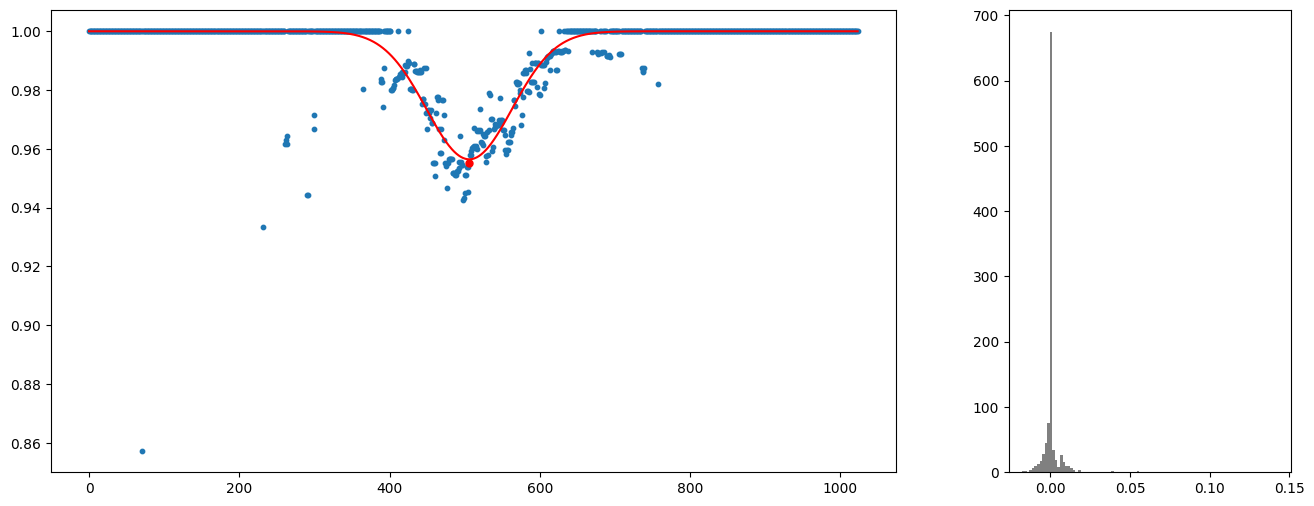

In [139]:
'''Профиль по оси j (для величины w_x)'''
data = 1-M[ic_abs, :] #без медианного сглаживания шумы слишком сильные, чтобы сигнал был различим
arg = np.arange(0, columns, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
fwhm_abs = out.params["fwhm"].value
w_abs = out.params["sigma"].value
peak_abs = out.params["height"].value

print("fwhm: %.3f ± %.3f px" % (fwhm_abs, out.params["fwhm"].stderr)) #stderr соответствует p = 0.68 (1-сигма)
#print("w_x: %.3f ± %.3f px" % (w_abs, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (peak_abs*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
#print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(jc_abs, 1-data[jc_abs], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

#### Расчёт концентрации

In [140]:
'''Расчет пиковой концентрации.'''
#peak = -np.log(1-peak_abs)/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection)
print("peak: %.2e cm^-3" % peak)
k=0.1
print("Reading error: \033[31m%.3e\033[0m" % (k*peak))

peak: 5.82e+08 cm^-3
Reading error: 5.820e+07



n0: 5.82e+08 cm^-3
(x1.0)


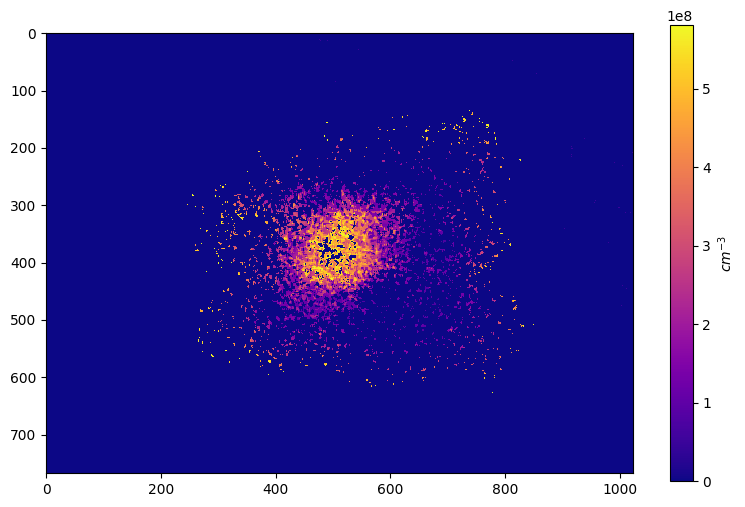


n0: 6.40e+08 cm^-3
(x1.1)


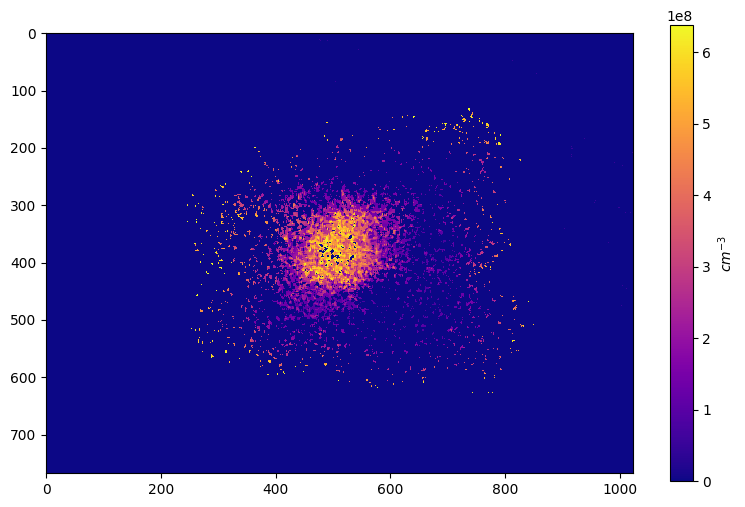


n0: 6.98e+08 cm^-3
(x1.2)


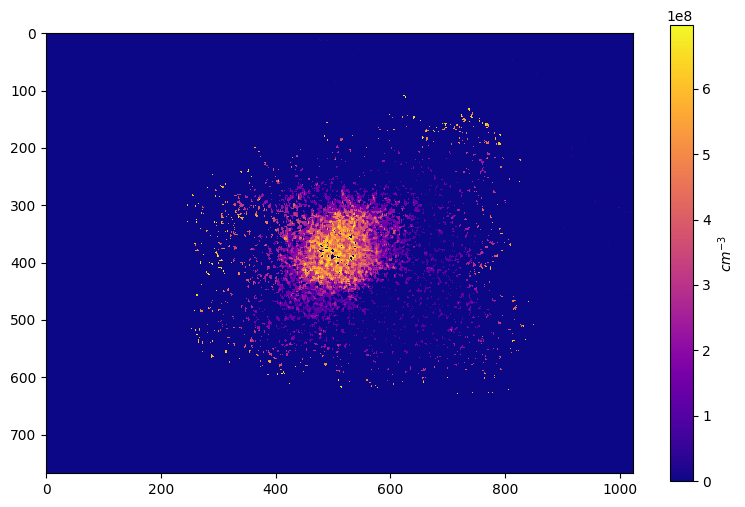


n0: 7.57e+08 cm^-3
(x1.3)


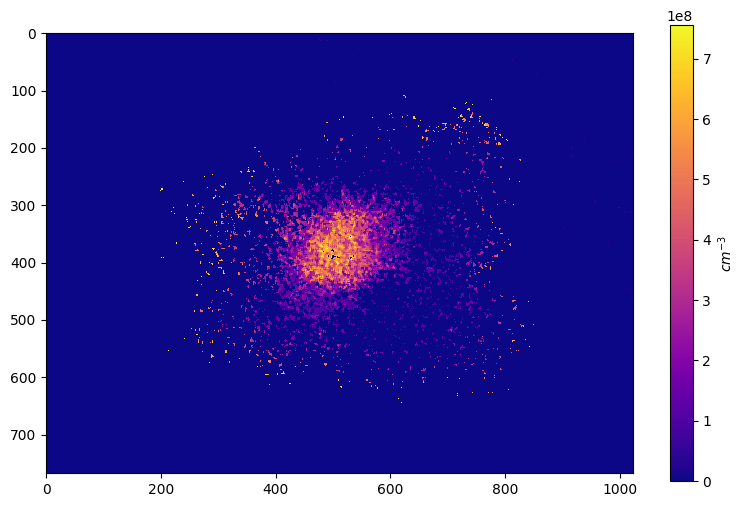


n0: 8.15e+08 cm^-3
(x1.4)


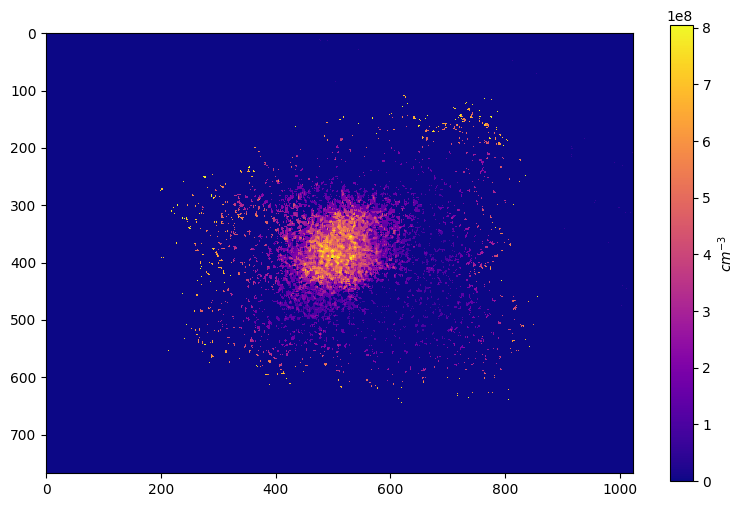


n0: 8.73e+08 cm^-3
(x1.5)


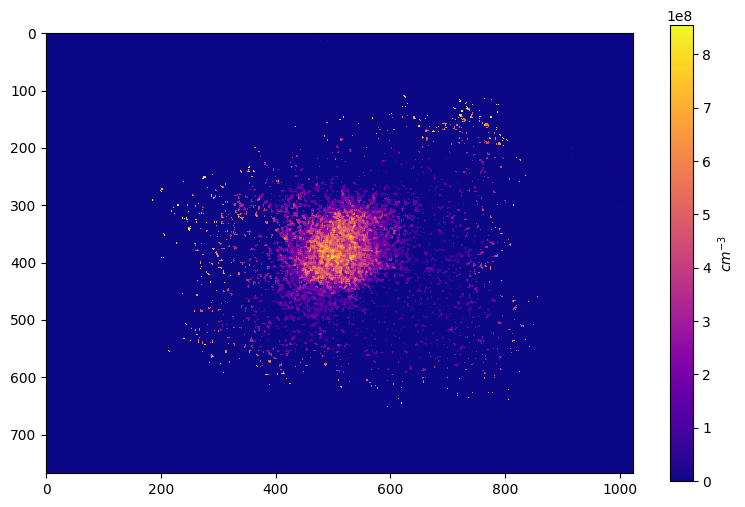


n0: 9.31e+08 cm^-3
(x1.6)


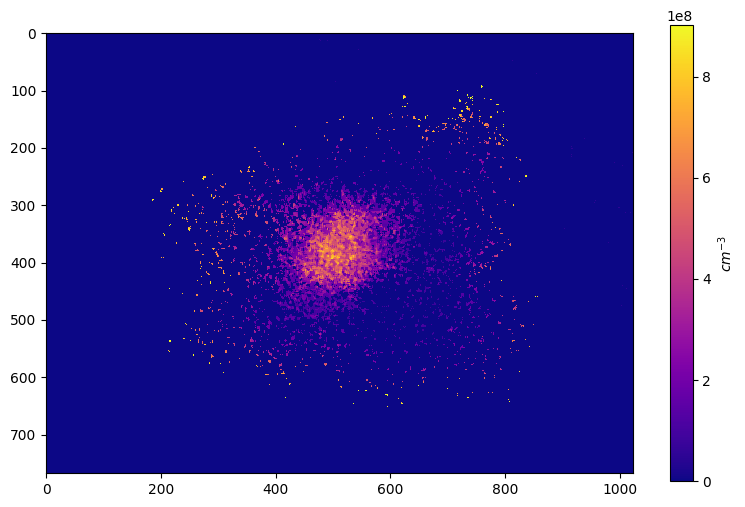


n0: 9.89e+08 cm^-3
(x1.7)


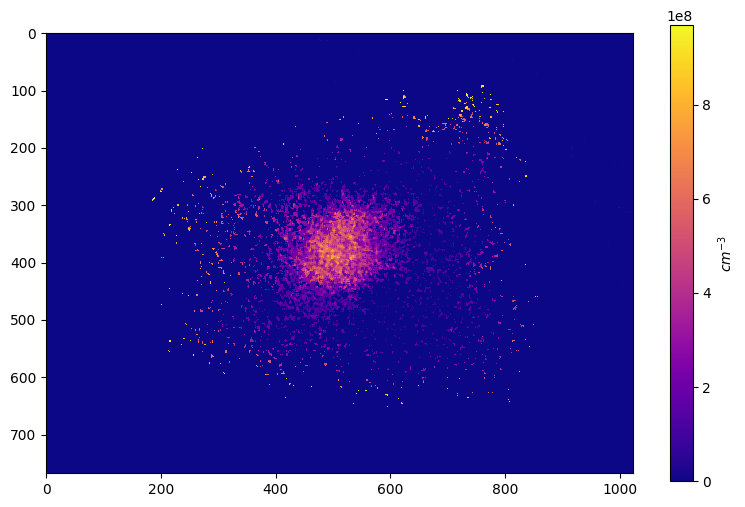

In [142]:
'''Профиль концентрации атомов n(x, y)'''
for mul in range(10, 18, 1):
    n = -np.log(M)/(np.sqrt(2*np.pi)*w_abs*Kx_abs*crosssection).astype(np.float32)
    n0 = (k*mul)*peak #медианное сглаживание портит амплитуду, поэтому её приходится поправлять
    print("\nn0: %.2e cm^-3" % n0)
    print("(x%.1f)" % (mul/10.0))

    '''Фильтрация физичных плотностей'''
    for i in range(rows): #rows
        for j in range(columns): #columns
            if n[i, j] < 0.:
                n[i, j] = 0.
            elif n[i, j] > n0:
                n[i, j] = 0.
    
    '''Визуализация'''
    plt.figure(figsize=(8, 6))
    plt.imshow(n, cmap="plasma", interpolation="none")
    plt.colorbar(shrink=.8, label="$cm^{-3}$")
    plt.tight_layout()
    plt.show()
    #plt.savefig(directory + file_abs + "_n0=%.3e.png"%n0)